In [1]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from shapely import geometry
from shapely.ops import cascaded_union
import osmnx as ox
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel

SQLalchemy is not installed. No support for SQL output.


In [14]:
training_folder = './../../'
input_folder = training_folder + 'inputs/'
input_path = training_folder + 'input/zones/'

## Zones

Load zone data from the input files

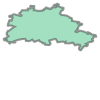

In [3]:
zones = gpd.read_file(input_path + "Berliner_Ortsteile.shp")
zones = zones.to_crs(epsg=4326)
#hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull = cascaded_union([x.buffer(1e-3) for x in zones['geometry']])
hull

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

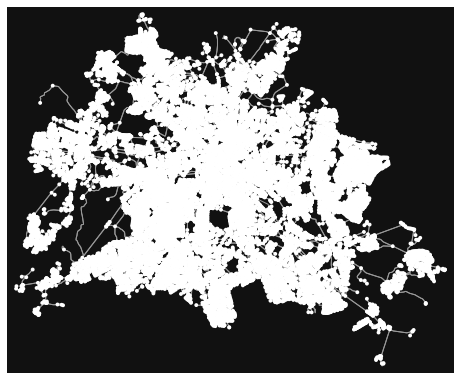

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
ox.plot_graph(drive)

In [5]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [6]:
# Let's have a look at the results
road_nodes.head(2)

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172539,52.565205,13.335501,3,NaN,NaN,POINT (13.33550 52.56521)
172545,52.567033,13.346605,4,NaN,NaN,POINT (13.34661 52.56703)


In [7]:
road_links.head(2)

osmid lanes             name    highway maxspeed  \
u      v        key                                                       
172539 34694265 0    4610047     2  Holländerstraße   tertiary       50   
       34694336 0    5117633     2   Gotthardstraße  secondary       50   

                     oneway   length  \
u      v        key                    
172539 34694265 0     False  237.653   
       34694336 0     False  687.484   

                                                              geometry  ref  \
u      v        key                                                           
172539 34694265 0    LINESTRING (13.33550 52.56521, 13.33560 52.565...  NaN   
       34694336 0    LINESTRING (13.33550 52.56521, 13.33565 52.565...  NaN   

                    bridge width tunnel junction access service area est_width  
u      v        key                                                             
172539 34694265 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN  
       34694336 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN

In [8]:
#road_links.plot(figsize=(16,9))

In [9]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [8]:
road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()

In [9]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [10]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [11]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [12]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

<AxesSubplot:>

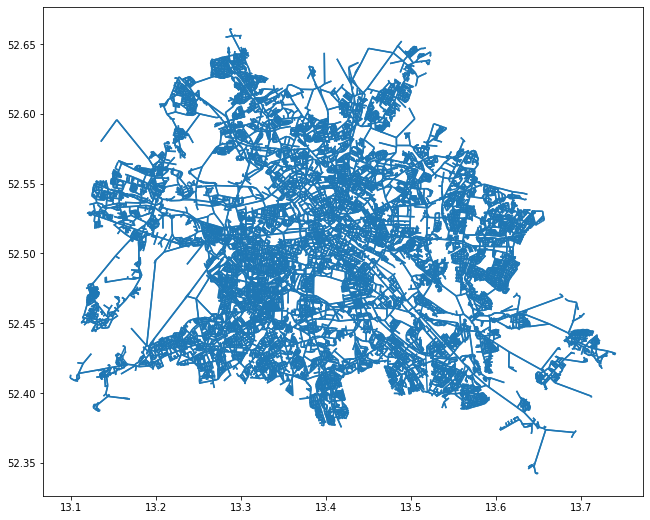

In [15]:
#road_links.plot(figsize=(16,9))

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [30]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path='../../input/vbb_gtfs.zip', dist_units='m') 
# full_feed = importer.GtfsImporter(path=input_path + r'/GTFS.zip', dist_units='m') 
# downloaded from http://vbb.de/vbbgtfs
#print(full_feed.stops)

In [49]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
start = min(full_feed.calendar['start_date'])
end = max(full_feed.calendar['end_date'])
feed_r = full_feed.restrict(
    dates=[start,start] # the dates must be within the feed start and end dates
)

In [50]:
feed_r.calendar_dates

,service_id,date,exception_type
0,1859,20220909,1
1,822,20220909,1
2,892,20220909,1
3,1260,20220909,1
4,363,20220909,1
...,...,...,...
1291,976,20220909,1
1292,97,20220909,1
1293,1180,20220909,1
1294,1787,20220909,1


In [51]:
# We can also restrict it to hours
# TODO: nothing between 8 and 9 am?
time_range = ['16:00:00', '17:00:00']
feed_t = feed_r.restrict(time_range=time_range)
print(feed_t.stops)

                       stop_id stop_code                 stop_name stop_desc  \
2      de:12070:900215110:1:50       NaN     Bad Wilsnack, Bahnhof       NaN   
3      de:12070:900215110:2:51       NaN     Bad Wilsnack, Bahnhof       NaN   
4      de:12062:900415465:1:50       NaN           Prösen, Bahnhof       NaN   
6      de:12072:900245025:2:51       NaN        Rangsdorf, Bahnhof       NaN   
8             de:14713:8010205       NaN     Leipzig, Hauptbahnhof       NaN   
...                        ...       ...                       ...       ...   
28155        de:14626:8226:0:2       NaN  Bad Muskau, Maßmannplatz       NaN   
28157        de:14626:8231:0:2       NaN     Bad Muskau, Lindenhof       NaN   
28159        de:14626:8232:0:2       NaN      Bad Muskau, Siedlung       NaN   
28164    de:11000:900135001::9       NaN           S Buch (Berlin)       NaN   
28165    de:12069:900220019::9       NaN   Stahnsdorf, Waldschänke       NaN   

        stop_lat   stop_lon  location_t

In [53]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [114]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [88]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='2']

,service_id,date,exception_type
142,2,20220909,1
790,2,20220909,1


In [91]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='1384']

,service_id,date,exception_type
195,1384,20220909,1
843,1384,20220909,1


In [124]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

{'892': 2, '98': 2, '1900': 2, '66': 2, '720': 2, '1756': 2, '1875': 2, '1878': 2, '713': 2, '470': 2, '1582': 2, '127': 2, '1742': 2, '2': 2, '554': 2, '406': 2, '686': 2, '1172': 2, '179': 2, '256': 2, '1344': 2, '182': 2, '251': 2, '176': 2, '1724': 2, '1384': 2, '296': 2, '1181': 2, '371': 2, '821': 2, '760': 2, '1365': 2, '1779': 2, '990': 2, '94': 2, '718': 2, '153': 2, '253': 2, '1175': 2, '1827': 2, '523': 2, '38': 2, '315': 2, '255': 2, '177': 2, '993': 2, '1359': 2, '1717': 2, '154': 2, '547': 2, '49': 2, '589': 2, '50': 2, '1419': 2, '25': 2, '1881': 2, '1580': 2, '482': 2, '1356': 2, '1361': 2, '178': 2, '545': 2, '1569': 2, '755': 2, '1591': 2, '1051': 2, '680': 2, '44': 2, '1618': 2, '1033': 2, '1588': 2, '511': 2, '1669': 2, '525': 2, '180': 2, '1663': 2, '932': 2, '1397': 2, '1621': 2, '1608': 2, '1766': 2, '346': 2, '514': 2}


In [135]:
# keep only first occurence of service_id by filtering calendar_dates
bool_indices = [x not in list(feed_s.calendar_dates['service_id'].iloc[0:n]) for n, x in enumerate(feed_s.calendar_dates['service_id'])]
feed_s.calendar_dates = feed_s.calendar_dates[bool_indices]


In [137]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

False {'892': 1, '98': 1, '1900': 1, '66': 1, '720': 1, '1756': 1, '1875': 1, '1878': 1, '713': 1, '470': 1, '1582': 1, '127': 1, '1742': 1, '2': 1, '554': 1, '406': 1, '686': 1, '1172': 1, '179': 1, '256': 1, '1344': 1, '182': 1, '251': 1, '176': 1, '1724': 1, '1384': 1, '296': 1, '1181': 1, '371': 1, '821': 1, '760': 1, '1365': 1, '1779': 1, '990': 1, '94': 1, '718': 1, '153': 1, '253': 1, '1175': 1, '1827': 1, '523': 1, '38': 1, '315': 1, '255': 1, '177': 1, '993': 1, '1359': 1, '1717': 1, '154': 1, '547': 1, '49': 1, '589': 1, '50': 1, '1419': 1, '25': 1, '1881': 1, '1580': 1, '482': 1, '1356': 1, '1361': 1, '178': 1, '545': 1, '1569': 1, '755': 1, '1591': 1, '1051': 1, '680': 1, '44': 1, '1618': 1, '1033': 1, '1588': 1, '511': 1, '1669': 1, '525': 1, '180': 1, '1663': 1, '932': 1, '1397': 1, '1621': 1, '1608': 1, '1766': 1, '346': 1, '514': 1}


In [107]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_s.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters


In [ ]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

In [ ]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

In [ ]:
feed_frequencies.links.head(2)

In [ ]:
feed_frequencies.nodes.head(1)

In [ ]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

In [ ]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

In [ ]:
# Plot the results using matplotlib notation
ax = zones.plot(alpha=0.5, figsize=[17, 7])
ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [ ]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')

In [ ]:
# Save zones into the model
sm.zones = zones

In [ ]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed']]
sm.road_nodes = oc.nodes[['geometry']]

In [ ]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'route_color', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [ ]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

In [ ]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

In [ ]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

In [ ]:
# Test
sm.integrity_test_all(errors='raise')

## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.

In [ ]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=300)
sm.nodes.head(1)

In [ ]:
len(sm.nodes)

In [ ]:
# Now, some links might go from one stop to the same
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]

In [ ]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

In [ ]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

In [ ]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [ ]:
sm.links.sample()

## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [ ]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

In [ ]:
len(sm.footpaths)

In [ ]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [ ]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

In [ ]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

In [ ]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

# Networkcaster

## Rail

In [ ]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

## Road

In [ ]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [ ]:
len(sm.road_nodes), len(sm.road_links)

In [ ]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

## both road and rail

In [ ]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 

In [ ]:
both.analysis_lines(line_columns='all')

# monitoring

In [ ]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

In [ ]:
lines.head(2)

In [ ]:
# summary
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

In [ ]:
ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

In [ ]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    # print(0)
    buffer = raw.copy()
    buffer_width = max(raw.zones['geometry'].apply(lambda g: max(abs(g.bounds[0]-g.bounds[2]), abs(g.bounds[1]-g.bounds[3]))))
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(buffer_width))
    # print(1)
    plot = raw.plot(
        'road_nodes', markersize=0.3, color='green',
        ax=raw.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0, ax=ax_array[0][0])
                  ),
        basemap_url=url,title="Road network", fontsize=36
    )
    # print(2)
    plot = raw.plot('links', 
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[0][1]),
        basemap_url=url, title="GTFS", fontsize=36
    )
    # print(3)
    plot = raw.plot('links', ax=raw.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[1][0])),
        basemap_url=url,title="raw GTFS & road network", fontsize=36
    )
    # print(4)
    plot = processed.plot(
        'links', 
        ax=processed.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                     ax=buffer.plot('zones', alpha=0, ax=ax_array[1][1])),
        basemap_url=url,title="Processed GTFS & Road Network", fontsize=36
    )
    # print(5)
    return fig

In [ ]:
sm.zones['geometry'].plot()

In [ ]:
help(sm.plot)

In [ ]:
# fig, ax_array = plt.subplots(2, 2,  figsize=[25, 25], tight_layout=True) 
buffer = sm.copy()
buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(0.04))
sm.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0.01), basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tile4/tile16/tile11.png'
                  , figsize=[20,20])

In [ ]:
fig, ax_array = plt.subplots(2, 2,  figsize=[25, 25], tight_layout=True) 
buffer = sm.copy()
buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(500))
sm.plot('road_nodes', markersize=0.3, color='green',
        ax=sm.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0, ax=ax_array[0][0])
                  ),
        basemap_url=url,title="Road network", fontsize=36
    )

In [ ]:
fig = plot_networkcaster(raw=sm, processed=both, url=url)

## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [ ]:
#sm.to_json('../../model/network')
both.to_json('../model/network')

In [ ]:
sm.road_links